## Dependencias

In [231]:
import numpy as np
import pandas as pd
import re
import os

from collections import Counter
from functools import reduce

import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import cufflinks as cf
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from varclushi import VarClusHi

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)
cf.go_offline()

## Carga de datos de texto

In [232]:
ruta = 'data/opiniones_diplo/'
l = os.listdir(ruta)

df = pd.concat(map(lambda x:pd.read_csv(os.path.join(ruta,x)).assign(modulo=x[-13:-8]),l),ignore_index=True)
df.shape

(693, 10)

In [233]:
df['modulo'] = df['modulo'].map(str.strip).map(lambda x:x if x[0]=='M' else x[2:4]+x[0:2] )

## Preprocesamiento

In [234]:
df = df[['Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)',
        'En general, ¿Cuántas estrellas darías al módulo?','modulo']]
df.columns = ['texto','sentimiento','modulo']

In [235]:
df['sentimiento'] = (df['sentimiento']>=4).astype(int)

In [236]:
df.head()

,texto,sentimiento,modulo
0,El mejor curso que he tomado de ciencias de datos. Muy bueno.,1,M1G7
1,"Me gustaria un poco mas de bibliografia para cada tema, tal vez no se pueda como tal peros si como lo basico.",1,M1G7
2,Me gusta mucho que sea mucho contenido practico,1,M1G7
3,Excelente el modulo,1,M1G7
4,"Las explicaciones fueron muy claras, se cubrieron las horas establecidas y considero que fue una excelente introducción al mundo de la ciencia de datos, me gustó mucho.",1,M1G7


### Minúsculas

In [237]:
df['texto'] = df['texto'].map(str.lower).map(lambda x:x.replace('\n',' '))

In [238]:
df.head()

,texto,sentimiento,modulo
0,el mejor curso que he tomado de ciencias de datos. muy bueno.,1,M1G7
1,"me gustaria un poco mas de bibliografia para cada tema, tal vez no se pueda como tal peros si como lo basico.",1,M1G7
2,me gusta mucho que sea mucho contenido practico,1,M1G7
3,excelente el modulo,1,M1G7
4,"las explicaciones fueron muy claras, se cubrieron las horas establecidas y considero que fue una excelente introducción al mundo de la ciencia de datos, me gustó mucho.",1,M1G7


### Quitar stopwords

In [239]:
STOP_WORDS = STOP_WORDS.union(set(stopwords.words('spanish')))
STOP_WORDS = STOP_WORDS.union({'módulo','tema','modulo'})

df['texto'] = df['texto'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

### Lematización (buscar la raíz de la palabra)

In [241]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load('es_core_news_sm')

df['texto'] = df['texto'].map(nlp).map(lambda x:[w.lemma_ for w in x]).apply(" ".join)
df.head()

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


### Quitar puntuación

In [243]:
"""
re.sub: Patrón, sustitución, texto, juego de caracteres

r' --> Raw String
^ -->  Empieza por..
\w --> alfanuméricos
\s --> espacios
[] --> Incluír solo los caracteres del patrón indicado
"""

df['texto'] = df['texto'].map(lambda x:re.sub(r'[^\w\s]','',x, re.UNICODE))

In [244]:
df.head()

,texto,sentimiento,modulo
0,curso tomado ciencia dato bueno,1,M1G7
1,gustaria bibliografio tema pero basico,1,M1G7
2,gustar contenido practico,1,M1G7
3,excelente,1,M1G7
4,explicación claro cubrir establecido considerar excelente introducción mundo ciencia dato gustar mucho,1,M1G7


### Quitar hapaxes (tokens con frecuencia 1)

In [245]:
conteos = Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))

hapaxes = [t for t,count in conteos.items() if count == 1 or t == '']
df['texto'] = df['texto'].map(lambda x:[w for w in x.split(' ') if w not in hapaxes]).apply(" ".join)
df.head()

## Quitar Stopwords de nuevo 

In [247]:
df['texto'] = df['texto'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

,texto,sentimiento,modulo
0,curso tomado ciencia dato,1,M1G7
1,,1,M1G7
2,gustar contenido practico,1,M1G7
3,excelente,1,M1G7
4,explicación cubrir establecido considerar excelente introducción mundo ciencia dato gustar,1,M1G7


## Vectorizar texto

In [248]:
cv = CountVectorizer(encoding='utf8',max_features=100,ngram_range=(1,3))
cv.fit(df['texto'])
df_cv = pd.DataFrame(cv.transform(df['texto']).todense())
df_cv.columns = [f'w_{w}' for w in cv.get_feature_names()]

In [249]:
tfidf = TfidfVectorizer(encoding='utf8',max_features=100,ngram_range=(1,3))
tfidf.fit(df['texto'])
df_tfidf = pd.DataFrame(tfidf.transform(df['texto']).todense())
df_tfidf.columns = [f'wt_{w}' for w in tfidf.get_feature_names()]

## Reducción de dimensiones

In [250]:
vc = VarClusHi(df=df_cv,feat_list=df_cv.filter(like='w_').columns)
vc.varclus()
rs = vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])
best_cv = rs.groupby('Cluster').first()['Variable'].to_list()


In [251]:
vc = VarClusHi(df=df_tfidf,feat_list=df_tfidf.filter(like='wt_').columns)
vc.varclus()
rs = vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])
best_tfidf = rs.groupby('Cluster').first()['Variable'].to_list()


## Clustering

### Count-Vectorizer

In [252]:
X = df_cv[best_cv].copy()
X.shape

(693, 33)

In [253]:
l = []
for k in range(2,10):
    cl = GaussianMixture(n_components=k)
    cl.fit(X)
    l.append((k,silhouette_score(X,cl.predict(X))))
sil = pd.DataFrame(l,columns=['k','sil']).set_index('k')
sil.iplot(mode='lines+markers')

In [254]:
k = 5

In [255]:
cl = GaussianMixture(n_components=k)
cl.fit(X)

GaussianMixture(n_components=5)

In [256]:
df['cl_cv'] = cl.predict(X)

In [257]:
aux = df.drop('sentimiento',axis=1).groupby('cl_cv').agg(lambda x:" ".join(x))

In [258]:
aux['texto'] = aux['texto'].map(lambda x:[w for w in x.split(' ') if w not in ('\n','',' ')]).apply(" ".join)

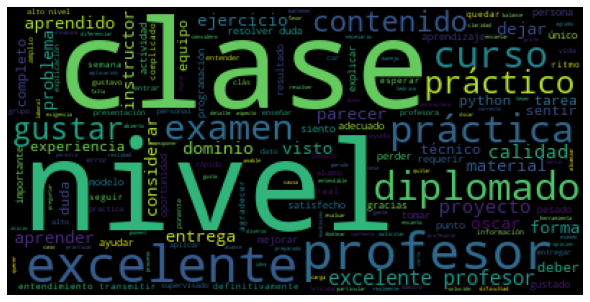

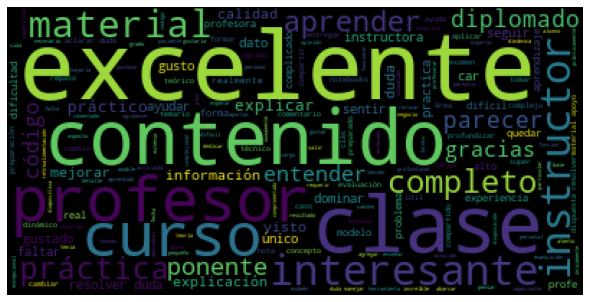

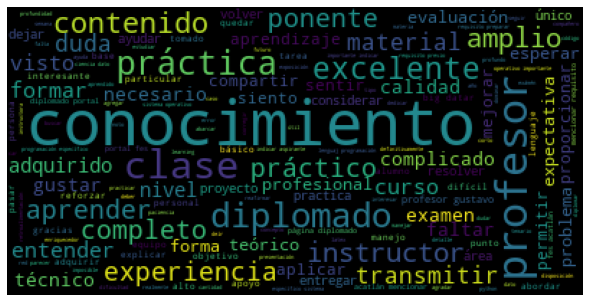

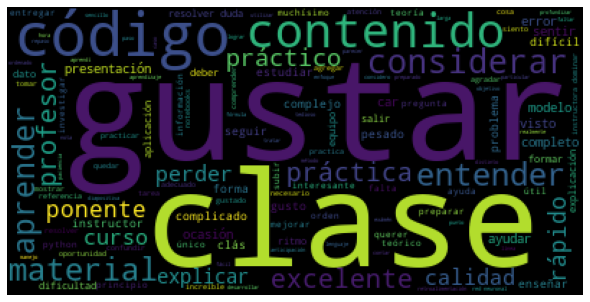

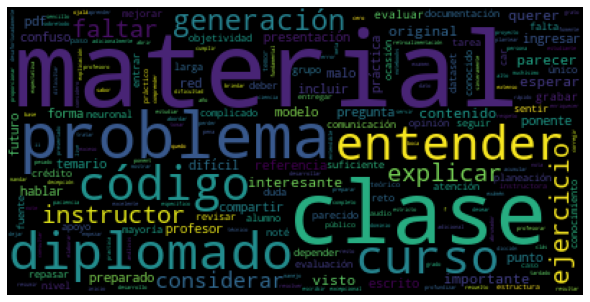

In [259]:
for i,row in aux.iterrows():
    wc = WordCloud()
    wc.generate_from_text(row['texto'])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [260]:
df.groupby('cl_cv').mean()

,sentimiento
cl_cv,
0,0.904192
1,0.937500
2,0.891892
3,0.801887
4,0.700000


### TF-IDF

In [261]:
X = df_tfidf[best_tfidf].copy()

In [262]:
l = []
for k in range(2,10):
    cl = GaussianMixture(n_components=k)
    cl.fit(X)
    l.append((k,silhouette_score(X,cl.predict(X))))
sil = pd.DataFrame(l,columns=['k','sil']).set_index('k')
sil.iplot(mode='lines+markers')

In [263]:
k = 5
cl = GaussianMixture(n_components=k)
cl.fit(X)

In [265]:
df['cl_tfidf'] = cl.predict(X)

In [266]:
aux = df.drop(['sentimiento','cl_cv'],axis=1).groupby('cl_tfidf').agg(lambda x:" ".join(x))
aux['texto'] = aux['texto'].map(lambda x:[w for w in x.split(' ') if w not in ('\n','',' ')]).apply(" ".join)

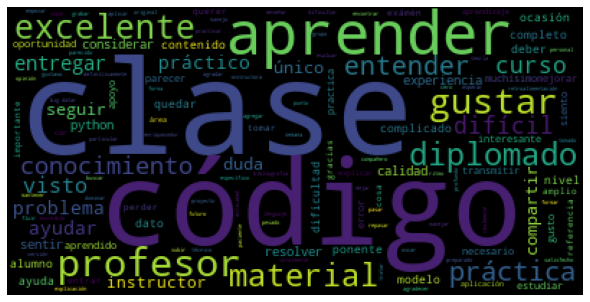

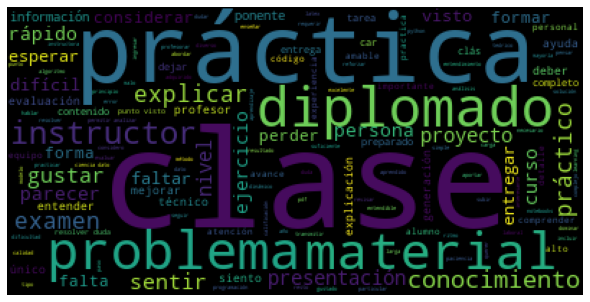

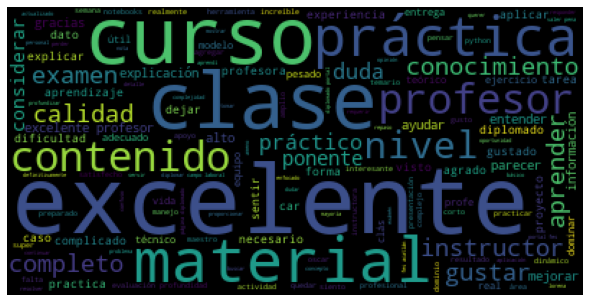

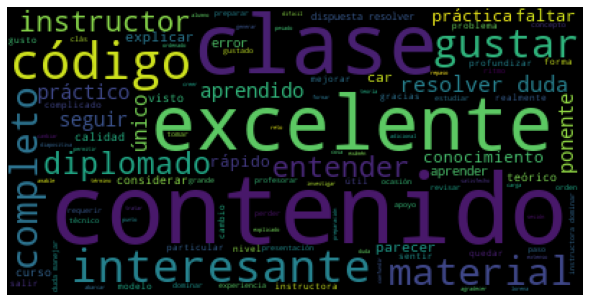

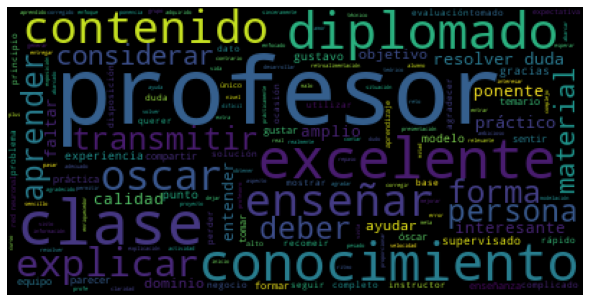

In [268]:
for i,row in aux.iterrows():
    wc = WordCloud()
    wc.generate_from_text(row['texto'])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [272]:
df.drop('cl_cv',axis=1).groupby('cl_tfidf').mean()

,sentimiento
cl_tfidf,
0,0.860759
1,0.760000
2,0.946015
3,0.888889
4,0.775510


## Positividad de Tokens

In [270]:
pos = pd.DataFrame(map(lambda w:(w[2:],df.loc[df_cv[w]>0]['sentimiento'].mean()),df_cv.columns))
pos.columns =['palabra','positividad']
pos = pos.sort_values(by='positividad',ascending=False).set_index('palabra')
pos.iplot(kind='bar')

## Vista por Módulo

In [290]:
df[['sentimiento','modulo']].groupby('modulo').mean().sort_values(by='sentimiento',ascending=False).iplot(kind='bar')
aux = df[['sentimiento','modulo']].copy()
aux['modulo'] = aux['modulo'].map(lambda x:x[:2])
aux.groupby('modulo').mean().sort_values(by='sentimiento',ascending=False).iplot(kind='bar')
aux = df[['sentimiento','modulo']].copy()
aux['modulo'] = aux['modulo'].map(lambda x:x[2:])
aux.groupby('modulo').mean().sort_values(by='sentimiento',ascending=False).iplot(kind='bar')


In [289]:
aux = df[['sentimiento','modulo']].copy()
aux['mod'] = aux['modulo'].map(lambda x:x[:2])
aux['gen'] = aux['modulo'].map(lambda x:x[2:])
aux = aux.pivot_table(index='gen',columns='mod',values='modulo',aggfunc='count')
aux['promedio'] = aux.mean(axis=1)
aux
#aux.groupby('modulo').count().sort_values(by='sentimiento',ascending=False).iplot(kind='bar')

mod,M1,M2,M3,M4,M5,promedio
gen,,,,,,
G2,NaN,NaN,NaN,24.0,29.0,26.500000
G3,NaN,NaN,NaN,61.0,19.0,40.000000
G4,NaN,27.0,28.0,30.0,29.0,28.500000
G5,38.0,34.0,36.0,62.0,38.0,41.600000
G6,37.0,40.0,33.0,NaN,NaN,36.666667
G7,41.0,36.0,NaN,NaN,NaN,38.500000
G8,51.0,NaN,NaN,NaN,NaN,51.000000


In [292]:
df[['texto','sentimiento']].to_pickle('texto_limpio.pkl')